In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.cm as cm
from sklearn.cluster import KMeans

In [2]:
features = pd.read_csv('C:\\Users\\user\\Desktop\\Макс диплом\\features.csv')
features.shape

(236, 323)

In [3]:
features = features.dropna()
features.shape

(235, 323)

In [4]:
features = features.replace('ALIVE (361 days later)', 1768) # max(Survival_days) + 1

In [5]:
survival_days_clustering = np.array(features['Survival_days']).reshape(-1, 1)
survival_days_clustering

array([['289'],
       ['616'],
       ['464'],
       ['788'],
       ['465'],
       ['269'],
       ['503'],
       ['1278'],
       ['1155'],
       ['515'],
       ['421'],
       ['495'],
       ['698'],
       ['359'],
       ['169'],
       ['368'],
       ['439'],
       ['486'],
       ['287'],
       ['55'],
       ['576'],
       ['350'],
       ['332'],
       ['331'],
       ['23'],
       ['203'],
       ['336'],
       ['106'],
       ['32'],
       ['466'],
       ['170'],
       ['488'],
       ['473'],
       ['1283'],
       ['33'],
       ['89'],
       ['172'],
       ['30'],
       ['84'],
       ['229'],
       ['286'],
       ['726'],
       ['495'],
       ['871'],
       ['210'],
       ['318'],
       ['208'],
       ['660'],
       ['522'],
       ['407'],
       ['265'],
       ['85'],
       ['597'],
       ['239'],
       ['610'],
       ['208'],
       ['355'],
       ['152'],
       ['385'],
       ['453'],
       ['1592'],
       ['376'],
       ['133

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


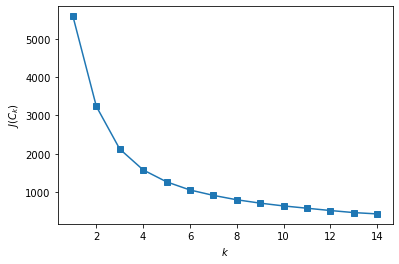

In [6]:
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=2021).fit(survival_days_clustering)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 15), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

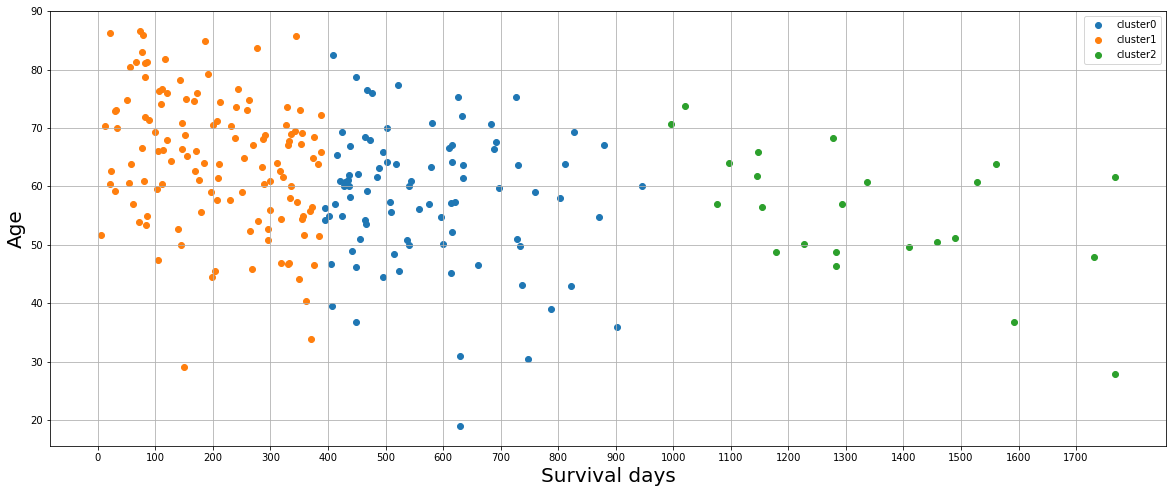

In [7]:
survival_days_kmeans = KMeans(n_clusters=3, random_state=2021).fit(survival_days_clustering)
pred_kmeans = survival_days_kmeans.predict(survival_days_clustering)

survival_days = np.array(features['Survival_days'].apply(lambda x: int(x)))
age = np.array(features['Age'])
plt.figure(figsize=(20,8))

plt.xticks(np.arange(0, max(survival_days), 100));
plt.grid(True)
plt.xlabel('Survival days', size=20);
plt.ylabel('Age', size=20);

for i in range(3):
    plt.scatter(survival_days[pred_kmeans==i], age[pred_kmeans==i], label=f'cluster{i}')
plt.legend()
plt.show()

In [8]:
def to_edge_clusters(survival_days, pred_kmeans, n_clusters):
    cluster_edges = []
    for i in range(n_clusters):
        cluster_edges.append([survival_days[pred_kmeans==i].min(), survival_days[pred_kmeans==i].max()])
    return cluster_edges

In [9]:
edges_clusters = to_edge_clusters(survival_days, pred_kmeans, 3)

for i in range(len(edges_clusters)):
    print(f'min :{edges_clusters[i][0]}, max: {edges_clusters[i][1]}')

min :394, max: 946
min :5, max: 387
min :996, max: 1768


In [10]:
def make_interval(days):
    if 0<=days<=387:
        return 0
    if 388<=days<=946:
        return 1
    if days >= 947:
        return 2

features['Survival_days'] = features['Survival_days'].apply(lambda x: int(x))
features['Survival_interval'] = features['Survival_days']
features['Survival_interval'] = features['Survival_interval'].map(make_interval)

In [11]:
y = features['Survival_interval']
X = features.drop(['Survival_days', 'Survival_interval'], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2021)
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)
y_train, y_test = np.array(y_train), np.array(y_test)

# Feature Selection and finding hyperparameters

In [13]:
from tqdm import tqdm

rfc = RandomForestClassifier(random_state=2021)


rfc_params = {'n_estimators': [100]}

cols = []
best_score = 0

for feature in tqdm(list(X.columns)):
    rfc_grid = GridSearchCV(rfc, rfc_params, n_jobs=-1, cv=5, verbose=1, scoring='f1_weighted')
    print('-'*30)
    print('Trying feature: ', feature)
    cols.append(feature)
    rfc_grid.fit(X[cols], y)
    print('CV_score:', rfc_grid.best_score_)
    if rfc_grid.best_score_ < best_score:
        cols.pop()
        print('Feature was not added')
    else:
        best_score = rfc_grid.best_score_
        best_rfc = rfc_grid
        print('Feature was added')
print('Best_score:', best_score)
print('Optimal features:', cols)

  0%|                                                                                          | 0/322 [00:00<?, ?it/s]

------------------------------
Trying feature:  ncr_original_shape_Elongation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  0%|▎                                                                                 | 1/322 [00:04<25:21,  4.74s/it]

CV_score: 0.3224170274706351
Feature was added
------------------------------
Trying feature:  ncr_original_shape_Flatness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  1%|▌                                                                                 | 2/322 [00:05<12:12,  2.29s/it]

CV_score: 0.39774012830938826
Feature was added
------------------------------
Trying feature:  ncr_original_shape_LeastAxisLength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  1%|▊                                                                                 | 3/322 [00:06<08:25,  1.58s/it]

CV_score: 0.45816307852738697
Feature was added
------------------------------
Trying feature:  ncr_original_shape_MajorAxisLength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  1%|█                                                                                 | 4/322 [00:06<06:28,  1.22s/it]

CV_score: 0.46426154363328553
Feature was added
------------------------------
Trying feature:  ncr_original_shape_Maximum2DDiameterColumn
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  2%|█▎                                                                                | 5/322 [00:07<05:16,  1.00it/s]

CV_score: 0.45993080468300784
Feature was not added
------------------------------
Trying feature:  ncr_original_shape_Maximum2DDiameterRow
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  2%|█▌                                                                                | 6/322 [00:08<04:48,  1.10it/s]

CV_score: 0.4981387024558341
Feature was added
------------------------------
Trying feature:  ncr_original_shape_Maximum2DDiameterSlice
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  2%|█▊                                                                                | 7/322 [00:08<04:17,  1.23it/s]

CV_score: 0.5154995295137359
Feature was added
------------------------------
Trying feature:  ncr_original_shape_Maximum3DDiameter
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  2%|██                                                                                | 8/322 [00:09<03:53,  1.35it/s]

CV_score: 0.5032536008625872
Feature was not added
------------------------------
Trying feature:  ncr_original_shape_MeshVolume
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  3%|██▎                                                                               | 9/322 [00:10<04:07,  1.26it/s]

CV_score: 0.5026721044941074
Feature was not added
------------------------------
Trying feature:  ncr_original_shape_MinorAxisLength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  3%|██▌                                                                              | 10/322 [00:11<04:23,  1.18it/s]

CV_score: 0.5007753211700579
Feature was not added
------------------------------
Trying feature:  ncr_original_shape_Sphericity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  3%|██▊                                                                              | 11/322 [00:11<03:57,  1.31it/s]

CV_score: 0.5067056890692905
Feature was not added
------------------------------
Trying feature:  ncr_original_shape_SurfaceArea
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  4%|███                                                                              | 12/322 [00:12<03:37,  1.42it/s]

CV_score: 0.5222254618517157
Feature was added
------------------------------
Trying feature:  ncr_original_shape_SurfaceVolumeRatio
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  4%|███▎                                                                             | 13/322 [00:12<03:27,  1.49it/s]

CV_score: 0.540367747933949
Feature was added
------------------------------
Trying feature:  ncr_original_shape_VoxelVolume
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  4%|███▌                                                                             | 14/322 [00:13<03:35,  1.43it/s]

CV_score: 0.5338718974985666
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_10Percentile
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  5%|███▊                                                                             | 15/322 [00:14<03:31,  1.45it/s]

CV_score: 0.503610816921699
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_90Percentile
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  5%|████                                                                             | 16/322 [00:14<03:26,  1.48it/s]

CV_score: 0.5133364862088267
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Energy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  5%|████▎                                                                            | 17/322 [00:15<03:26,  1.48it/s]

CV_score: 0.49105784420227805
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Entropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  6%|████▌                                                                            | 18/322 [00:16<03:27,  1.47it/s]

CV_score: 0.5084551757431733
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_InterquartileRange
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  6%|████▊                                                                            | 19/322 [00:17<03:29,  1.45it/s]

CV_score: 0.5242675021365603
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Kurtosis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  6%|█████                                                                            | 20/322 [00:17<03:24,  1.48it/s]

CV_score: 0.5583641420112739
Feature was added
------------------------------
Trying feature:  ncr_original_firstorder_Maximum
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  7%|█████▎                                                                           | 21/322 [00:18<03:14,  1.55it/s]

CV_score: 0.5222528742779909
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_MeanAbsoluteDeviation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  7%|█████▌                                                                           | 22/322 [00:18<03:14,  1.54it/s]

CV_score: 0.5131632562243841
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Mean
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  7%|█████▊                                                                           | 23/322 [00:19<03:08,  1.59it/s]

CV_score: 0.5274303593017705
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Median
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  7%|██████                                                                           | 24/322 [00:20<03:07,  1.59it/s]

CV_score: 0.5423002436808735
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Minimum
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  8%|██████▎                                                                          | 25/322 [00:20<03:04,  1.61it/s]

CV_score: 0.5015796717868651
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Range
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  8%|██████▌                                                                          | 26/322 [00:21<03:00,  1.64it/s]

CV_score: 0.5011410787620789
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_RobustMeanAbsoluteDeviation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  8%|██████▊                                                                          | 27/322 [00:21<03:02,  1.61it/s]

CV_score: 0.5222252973697326
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_RootMeanSquared
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  9%|███████                                                                          | 28/322 [00:22<03:00,  1.63it/s]

CV_score: 0.5247376488604407
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Skewness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  9%|███████▎                                                                         | 29/322 [00:23<03:07,  1.56it/s]

CV_score: 0.5177000859816243
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_TotalEnergy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


  9%|███████▌                                                                         | 30/322 [00:23<03:12,  1.52it/s]

CV_score: 0.5163522574259679
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Uniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 10%|███████▊                                                                         | 31/322 [00:24<03:19,  1.46it/s]

CV_score: 0.5340091052684381
Feature was not added
------------------------------
Trying feature:  ncr_original_firstorder_Variance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 10%|████████                                                                         | 32/322 [00:25<03:17,  1.47it/s]

CV_score: 0.52095460329437
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_Autocorrelation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 10%|████████▎                                                                        | 33/322 [00:26<03:17,  1.46it/s]

CV_score: 0.5192815188533519
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_ClusterProminence
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 11%|████████▌                                                                        | 34/322 [00:26<03:18,  1.45it/s]

CV_score: 0.5113869598247269
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_ClusterShade
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 11%|████████▊                                                                        | 35/322 [00:27<03:12,  1.49it/s]

CV_score: 0.5234109262489504
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_ClusterTendency
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 11%|█████████                                                                        | 36/322 [00:28<03:11,  1.50it/s]

CV_score: 0.5300784848735295
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_Contrast
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 11%|█████████▎                                                                       | 37/322 [00:28<03:12,  1.48it/s]

CV_score: 0.5274047752044464
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_Correlation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 12%|█████████▌                                                                       | 38/322 [00:29<03:05,  1.53it/s]

CV_score: 0.5344443260119105
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_DifferenceAverage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 12%|█████████▊                                                                       | 39/322 [00:30<03:07,  1.51it/s]

CV_score: 0.5153419540248714
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_DifferenceEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 12%|██████████                                                                       | 40/322 [00:30<03:00,  1.57it/s]

CV_score: 0.5341648709868417
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_DifferenceVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 13%|██████████▎                                                                      | 41/322 [00:31<02:57,  1.58it/s]

CV_score: 0.5326978397305077
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_Id
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 13%|██████████▌                                                                      | 42/322 [00:31<02:59,  1.56it/s]

CV_score: 0.5129920335327469
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_Idm
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 13%|██████████▊                                                                      | 43/322 [00:32<02:54,  1.60it/s]

CV_score: 0.5281723136051026
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_Idmn
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 14%|███████████                                                                      | 44/322 [00:33<02:54,  1.60it/s]

CV_score: 0.5267120036572054
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_Idn
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 14%|███████████▎                                                                     | 45/322 [00:33<02:54,  1.58it/s]

CV_score: 0.5588985903480675
Feature was added
------------------------------
Trying feature:  ncr_original_glcm_Imc1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 14%|███████████▌                                                                     | 46/322 [00:34<02:53,  1.59it/s]

CV_score: 0.5528395802668067
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_Imc2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 15%|███████████▊                                                                     | 47/322 [00:34<02:50,  1.61it/s]

CV_score: 0.53738819344557
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_InverseVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 15%|████████████                                                                     | 48/322 [00:35<02:53,  1.58it/s]

CV_score: 0.5379788885007672
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_JointAverage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 15%|████████████▎                                                                    | 49/322 [00:36<02:51,  1.59it/s]

CV_score: 0.5496508073595707
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_JointEnergy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 16%|████████████▌                                                                    | 50/322 [00:36<02:47,  1.63it/s]

CV_score: 0.5499072709683541
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_JointEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 16%|████████████▊                                                                    | 51/322 [00:37<02:44,  1.64it/s]

CV_score: 0.5183684378269829
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_MCC
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 16%|█████████████                                                                    | 52/322 [00:38<02:42,  1.66it/s]

CV_score: 0.557935828885112
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_MaximumProbability
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 16%|█████████████▎                                                                   | 53/322 [00:38<02:39,  1.68it/s]

CV_score: 0.5202969951440256
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_SumAverage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 17%|█████████████▌                                                                   | 54/322 [00:39<02:38,  1.69it/s]

CV_score: 0.5496508073595707
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_SumEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 17%|█████████████▊                                                                   | 55/322 [00:39<02:37,  1.69it/s]

CV_score: 0.5321081481366294
Feature was not added
------------------------------
Trying feature:  ncr_original_glcm_SumSquares
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 17%|██████████████                                                                   | 56/322 [00:40<02:41,  1.64it/s]

CV_score: 0.5385618867177213
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_DependenceEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 18%|██████████████▎                                                                  | 57/322 [00:41<02:40,  1.65it/s]

CV_score: 0.5355930795628756
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_DependenceNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 18%|██████████████▌                                                                  | 58/322 [00:41<02:40,  1.64it/s]

CV_score: 0.5491356997812471
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_DependenceNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 18%|██████████████▊                                                                  | 59/322 [00:42<02:42,  1.62it/s]

CV_score: 0.5402143452174619
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_DependenceVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 19%|███████████████                                                                  | 60/322 [00:43<02:51,  1.53it/s]

CV_score: 0.5464981438910453
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_GrayLevelNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 19%|███████████████▎                                                                 | 61/322 [00:43<02:47,  1.56it/s]

CV_score: 0.5486629359684805
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_GrayLevelVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 19%|███████████████▌                                                                 | 62/322 [00:44<02:52,  1.50it/s]

CV_score: 0.5204604064471113
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_HighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 20%|███████████████▊                                                                 | 63/322 [00:45<03:18,  1.30it/s]

CV_score: 0.5616533948945017
Feature was added
------------------------------
Trying feature:  ncr_original_gldm_LargeDependenceEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 20%|████████████████                                                                 | 64/322 [00:46<03:34,  1.20it/s]

CV_score: 0.5404345918918163
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_LargeDependenceHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 20%|████████████████▎                                                                | 65/322 [00:47<03:33,  1.20it/s]

CV_score: 0.5434794844856992
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_LargeDependenceLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 20%|████████████████▌                                                                | 66/322 [00:48<03:38,  1.17it/s]

CV_score: 0.5307722117594078
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_LowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 21%|████████████████▊                                                                | 67/322 [00:48<03:26,  1.24it/s]

CV_score: 0.5465683419599368
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_SmallDependenceEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 21%|█████████████████                                                                | 68/322 [00:49<03:20,  1.27it/s]

CV_score: 0.5257200386157069
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_SmallDependenceHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 21%|█████████████████▎                                                               | 69/322 [00:50<03:28,  1.21it/s]

CV_score: 0.5193156715953068
Feature was not added
------------------------------
Trying feature:  ncr_original_gldm_SmallDependenceLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 22%|█████████████████▌                                                               | 70/322 [00:51<03:42,  1.13it/s]

CV_score: 0.5500802530169178
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_GrayLevelNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 22%|█████████████████▊                                                               | 71/322 [00:52<03:52,  1.08it/s]

CV_score: 0.5138003966261746
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_GrayLevelNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 22%|██████████████████                                                               | 72/322 [00:53<03:45,  1.11it/s]

CV_score: 0.5375208360799896
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_GrayLevelVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 23%|██████████████████▎                                                              | 73/322 [00:54<03:46,  1.10it/s]

CV_score: 0.516253275930985
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_HighGrayLevelRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 23%|██████████████████▌                                                              | 74/322 [00:54<03:24,  1.21it/s]

CV_score: 0.5180680781101206
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_LongRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 23%|██████████████████▊                                                              | 75/322 [00:55<03:06,  1.33it/s]

CV_score: 0.5579127815381826
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_LongRunHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 24%|███████████████████                                                              | 76/322 [00:56<02:53,  1.42it/s]

CV_score: 0.5189870879622045
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_LongRunLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 24%|███████████████████▎                                                             | 77/322 [00:57<03:12,  1.27it/s]

CV_score: 0.5282351875110953
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_LowGrayLevelRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 24%|███████████████████▌                                                             | 78/322 [00:57<03:10,  1.28it/s]

CV_score: 0.5396663661894262
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_RunEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 25%|███████████████████▊                                                             | 79/322 [00:59<03:42,  1.09it/s]

CV_score: 0.539108478678385
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_RunLengthNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 25%|████████████████████                                                             | 80/322 [00:59<03:21,  1.20it/s]

CV_score: 0.5223553672489842
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_RunLengthNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 25%|████████████████████▍                                                            | 81/322 [01:00<03:03,  1.31it/s]

CV_score: 0.5602752492614529
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_RunPercentage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 25%|████████████████████▋                                                            | 82/322 [01:01<03:10,  1.26it/s]

CV_score: 0.5741976540263027
Feature was added
------------------------------
Trying feature:  ncr_original_glrlm_RunVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 26%|████████████████████▉                                                            | 83/322 [01:01<03:00,  1.33it/s]

CV_score: 0.5344794165944198
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_ShortRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 26%|█████████████████████▏                                                           | 84/322 [01:02<02:53,  1.37it/s]

CV_score: 0.5442012434872154
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_ShortRunHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 26%|█████████████████████▍                                                           | 85/322 [01:03<02:44,  1.44it/s]

CV_score: 0.5392468618485091
Feature was not added
------------------------------
Trying feature:  ncr_original_glrlm_ShortRunLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 27%|█████████████████████▋                                                           | 86/322 [01:03<02:53,  1.36it/s]

CV_score: 0.5565346019041428
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_GrayLevelNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 27%|█████████████████████▉                                                           | 87/322 [01:04<02:59,  1.31it/s]

CV_score: 0.5208506834950433
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_GrayLevelNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 27%|██████████████████████▏                                                          | 88/322 [01:05<02:45,  1.41it/s]

CV_score: 0.526803153779001
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_GrayLevelVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 28%|██████████████████████▍                                                          | 89/322 [01:05<02:38,  1.47it/s]

CV_score: 0.5274554074047417
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_HighGrayLevelZoneEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 28%|██████████████████████▋                                                          | 90/322 [01:06<02:42,  1.43it/s]

CV_score: 0.5433174558582723
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_LargeAreaEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 28%|██████████████████████▉                                                          | 91/322 [01:07<03:17,  1.17it/s]

CV_score: 0.5401578223745146
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_LargeAreaHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 29%|███████████████████████▏                                                         | 92/322 [01:09<03:39,  1.05it/s]

CV_score: 0.518517649899137
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_LargeAreaLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 29%|███████████████████████▍                                                         | 93/322 [01:10<03:44,  1.02it/s]

CV_score: 0.5301987525407661
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_LowGrayLevelZoneEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 29%|███████████████████████▋                                                         | 94/322 [01:11<03:58,  1.04s/it]

CV_score: 0.5555335157653959
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_SizeZoneNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 30%|███████████████████████▉                                                         | 95/322 [01:12<04:15,  1.13s/it]

CV_score: 0.5480516969191759
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_SizeZoneNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 30%|████████████████████████▏                                                        | 96/322 [01:13<04:16,  1.14s/it]

CV_score: 0.5109678344857487
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_SmallAreaEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 30%|████████████████████████▍                                                        | 97/322 [01:14<04:07,  1.10s/it]

CV_score: 0.5010275401988727
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_SmallAreaHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 30%|████████████████████████▋                                                        | 98/322 [01:15<03:37,  1.03it/s]

CV_score: 0.5207804905083868
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_SmallAreaLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 31%|████████████████████████▉                                                        | 99/322 [01:16<03:12,  1.16it/s]

CV_score: 0.5215503342129411
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_ZoneEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 31%|████████████████████████▊                                                       | 100/322 [01:16<02:56,  1.26it/s]

CV_score: 0.5228827140088376
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_ZonePercentage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 31%|█████████████████████████                                                       | 101/322 [01:17<02:55,  1.26it/s]

CV_score: 0.5375274292576581
Feature was not added
------------------------------
Trying feature:  ncr_original_glszm_ZoneVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 32%|█████████████████████████▎                                                      | 102/322 [01:18<02:44,  1.34it/s]

CV_score: 0.5449765907212716
Feature was not added
------------------------------
Trying feature:  ncr_original_ngtdm_Busyness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 32%|█████████████████████████▌                                                      | 103/322 [01:18<02:36,  1.40it/s]

CV_score: 0.5423391106330211
Feature was not added
------------------------------
Trying feature:  ncr_original_ngtdm_Coarseness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 32%|█████████████████████████▊                                                      | 104/322 [01:19<02:35,  1.40it/s]

CV_score: 0.5250905737434952
Feature was not added
------------------------------
Trying feature:  ncr_original_ngtdm_Complexity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 33%|██████████████████████████                                                      | 105/322 [01:20<02:28,  1.46it/s]

CV_score: 0.5427995737453359
Feature was not added
------------------------------
Trying feature:  ncr_original_ngtdm_Contrast
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 33%|██████████████████████████▎                                                     | 106/322 [01:20<02:27,  1.46it/s]

CV_score: 0.5179515069083398
Feature was not added
------------------------------
Trying feature:  ncr_original_ngtdm_Strength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 33%|██████████████████████████▌                                                     | 107/322 [01:21<02:24,  1.48it/s]

CV_score: 0.5246203512319203
Feature was not added
------------------------------
Trying feature:  ed_original_shape_Elongation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 34%|██████████████████████████▊                                                     | 108/322 [01:22<02:20,  1.53it/s]

CV_score: 0.5264555590996506
Feature was not added
------------------------------
Trying feature:  ed_original_shape_Flatness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 34%|███████████████████████████                                                     | 109/322 [01:22<02:16,  1.56it/s]

CV_score: 0.534477503404658
Feature was not added
------------------------------
Trying feature:  ed_original_shape_LeastAxisLength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 34%|███████████████████████████▎                                                    | 110/322 [01:23<02:14,  1.57it/s]

CV_score: 0.5363274101979261
Feature was not added
------------------------------
Trying feature:  ed_original_shape_MajorAxisLength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 34%|███████████████████████████▌                                                    | 111/322 [01:23<02:17,  1.53it/s]

CV_score: 0.5165694427195833
Feature was not added
------------------------------
Trying feature:  ed_original_shape_Maximum2DDiameterColumn
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 35%|███████████████████████████▊                                                    | 112/322 [01:24<02:13,  1.58it/s]

CV_score: 0.49529981940558476
Feature was not added
------------------------------
Trying feature:  ed_original_shape_Maximum2DDiameterRow
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 35%|████████████████████████████                                                    | 113/322 [01:25<02:09,  1.62it/s]

CV_score: 0.5423140014372589
Feature was not added
------------------------------
Trying feature:  ed_original_shape_Maximum2DDiameterSlice
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 35%|████████████████████████████▎                                                   | 114/322 [01:25<02:09,  1.60it/s]

CV_score: 0.5224445141867202
Feature was not added
------------------------------
Trying feature:  ed_original_shape_Maximum3DDiameter
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 36%|████████████████████████████▌                                                   | 115/322 [01:26<02:23,  1.45it/s]

CV_score: 0.553084090826052
Feature was not added
------------------------------
Trying feature:  ed_original_shape_MeshVolume
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 36%|████████████████████████████▊                                                   | 116/322 [01:27<02:16,  1.51it/s]

CV_score: 0.5331339024153872
Feature was not added
------------------------------
Trying feature:  ed_original_shape_MinorAxisLength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 36%|█████████████████████████████                                                   | 117/322 [01:27<02:11,  1.56it/s]

CV_score: 0.538044043964223
Feature was not added
------------------------------
Trying feature:  ed_original_shape_Sphericity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 37%|█████████████████████████████▎                                                  | 118/322 [01:28<02:08,  1.58it/s]

CV_score: 0.516496003330067
Feature was not added
------------------------------
Trying feature:  ed_original_shape_SurfaceArea
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 37%|█████████████████████████████▌                                                  | 119/322 [01:29<02:09,  1.57it/s]

CV_score: 0.5184557997323955
Feature was not added
------------------------------
Trying feature:  ed_original_shape_SurfaceVolumeRatio
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 37%|█████████████████████████████▊                                                  | 120/322 [01:29<02:17,  1.47it/s]

CV_score: 0.5039890508601397
Feature was not added
------------------------------
Trying feature:  ed_original_shape_VoxelVolume
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 38%|██████████████████████████████                                                  | 121/322 [01:30<02:11,  1.52it/s]

CV_score: 0.5203172046767547
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_10Percentile
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 38%|██████████████████████████████▎                                                 | 122/322 [01:31<02:07,  1.57it/s]

CV_score: 0.5323412727149589
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_90Percentile
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 38%|██████████████████████████████▌                                                 | 123/322 [01:31<02:08,  1.55it/s]

CV_score: 0.5423544314445806
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Energy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 39%|██████████████████████████████▊                                                 | 124/322 [01:32<02:10,  1.52it/s]

CV_score: 0.5570468219851422
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Entropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 39%|███████████████████████████████                                                 | 125/322 [01:33<02:11,  1.49it/s]

CV_score: 0.5093737893245092
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_InterquartileRange
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 39%|███████████████████████████████▎                                                | 126/322 [01:33<02:17,  1.42it/s]

CV_score: 0.533824473117933
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Kurtosis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 39%|███████████████████████████████▌                                                | 127/322 [01:34<02:16,  1.43it/s]

CV_score: 0.5147510622016401
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Maximum
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 40%|███████████████████████████████▊                                                | 128/322 [01:35<02:21,  1.37it/s]

CV_score: 0.5085330737875522
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_MeanAbsoluteDeviation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 40%|████████████████████████████████                                                | 129/322 [01:36<02:21,  1.37it/s]

CV_score: 0.5258930875099227
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Mean
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 40%|████████████████████████████████▎                                               | 130/322 [01:36<02:13,  1.43it/s]

CV_score: 0.5141181793809044
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Median
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 41%|████████████████████████████████▌                                               | 131/322 [01:37<02:10,  1.47it/s]

CV_score: 0.5310647004315864
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Minimum
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 41%|████████████████████████████████▊                                               | 132/322 [01:38<02:08,  1.48it/s]

CV_score: 0.5174647068761715
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Range
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 41%|█████████████████████████████████                                               | 133/322 [01:38<02:11,  1.44it/s]

CV_score: 0.5429884331680903
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_RobustMeanAbsoluteDeviation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 42%|█████████████████████████████████▎                                              | 134/322 [01:39<02:06,  1.49it/s]

CV_score: 0.5330262522955278
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_RootMeanSquared
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 42%|█████████████████████████████████▌                                              | 135/322 [01:40<02:01,  1.53it/s]

CV_score: 0.50676257515418
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Skewness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 42%|█████████████████████████████████▊                                              | 136/322 [01:40<01:59,  1.56it/s]

CV_score: 0.5171012908059602
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_TotalEnergy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 43%|██████████████████████████████████                                              | 137/322 [01:41<02:02,  1.51it/s]

CV_score: 0.5570468219851422
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Uniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 43%|██████████████████████████████████▎                                             | 138/322 [01:42<02:05,  1.46it/s]

CV_score: 0.5099569676431523
Feature was not added
------------------------------
Trying feature:  ed_original_firstorder_Variance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 43%|██████████████████████████████████▌                                             | 139/322 [01:42<02:12,  1.38it/s]

CV_score: 0.5429789612337975
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_Autocorrelation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 43%|██████████████████████████████████▊                                             | 140/322 [01:43<02:08,  1.42it/s]

CV_score: 0.5171298781732044
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_ClusterProminence
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 44%|███████████████████████████████████                                             | 141/322 [01:44<02:05,  1.44it/s]

CV_score: 0.5283363526060765
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_ClusterShade
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 44%|███████████████████████████████████▎                                            | 142/322 [01:45<02:11,  1.37it/s]

CV_score: 0.5020884421175132
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_ClusterTendency
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 44%|███████████████████████████████████▌                                            | 143/322 [01:45<02:05,  1.43it/s]

CV_score: 0.5293113165690915
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_Contrast
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 45%|███████████████████████████████████▊                                            | 144/322 [01:46<02:01,  1.46it/s]

CV_score: 0.5402611404044647
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_Correlation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 45%|████████████████████████████████████                                            | 145/322 [01:46<02:00,  1.47it/s]

CV_score: 0.5287809708022474
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_DifferenceAverage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 45%|████████████████████████████████████▎                                           | 146/322 [01:47<01:54,  1.53it/s]

CV_score: 0.5235780838151103
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_DifferenceEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 46%|████████████████████████████████████▌                                           | 147/322 [01:48<01:50,  1.58it/s]

CV_score: 0.5464923267015055
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_DifferenceVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 46%|████████████████████████████████████▊                                           | 148/322 [01:48<01:48,  1.60it/s]

CV_score: 0.5331681091719809
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_Id
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 46%|█████████████████████████████████████                                           | 149/322 [01:49<01:46,  1.62it/s]

CV_score: 0.5512154775822674
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_Idm
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 47%|█████████████████████████████████████▎                                          | 150/322 [01:50<01:48,  1.59it/s]

CV_score: 0.530153628407007
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_Idmn
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 47%|█████████████████████████████████████▌                                          | 151/322 [01:50<01:50,  1.54it/s]

CV_score: 0.5066918799032007
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_Idn
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 47%|█████████████████████████████████████▊                                          | 152/322 [01:51<01:55,  1.48it/s]

CV_score: 0.5328854788410015
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_Imc1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 48%|██████████████████████████████████████                                          | 153/322 [01:52<01:53,  1.49it/s]

CV_score: 0.49751394312018915
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_Imc2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 48%|██████████████████████████████████████▎                                         | 154/322 [01:52<01:54,  1.46it/s]

CV_score: 0.5094781759236461
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_InverseVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 48%|██████████████████████████████████████▌                                         | 155/322 [01:53<01:53,  1.47it/s]

CV_score: 0.5137275396151953
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_JointAverage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 48%|██████████████████████████████████████▊                                         | 156/322 [01:54<01:50,  1.50it/s]

CV_score: 0.5146576564991825
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_JointEnergy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 49%|███████████████████████████████████████                                         | 157/322 [01:54<01:47,  1.53it/s]

CV_score: 0.5466605287260415
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_JointEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 49%|███████████████████████████████████████▎                                        | 158/322 [01:55<01:45,  1.56it/s]

CV_score: 0.5319135218184561
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_MCC
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 49%|███████████████████████████████████████▌                                        | 159/322 [01:56<01:48,  1.51it/s]

CV_score: 0.5429543655569609
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_MaximumProbability
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 50%|███████████████████████████████████████▊                                        | 160/322 [01:56<01:48,  1.50it/s]

CV_score: 0.53872669388276
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_SumAverage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 50%|████████████████████████████████████████                                        | 161/322 [01:57<01:42,  1.57it/s]

CV_score: 0.5146576564991825
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_SumEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 50%|████████████████████████████████████████▏                                       | 162/322 [01:57<01:39,  1.61it/s]

CV_score: 0.5296018172176925
Feature was not added
------------------------------
Trying feature:  ed_original_glcm_SumSquares
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 51%|████████████████████████████████████████▍                                       | 163/322 [01:58<01:43,  1.53it/s]

CV_score: 0.5302418238825777
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_DependenceEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 51%|████████████████████████████████████████▋                                       | 164/322 [01:59<01:43,  1.52it/s]

CV_score: 0.511392499598273
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_DependenceNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 51%|████████████████████████████████████████▉                                       | 165/322 [02:00<01:45,  1.49it/s]

CV_score: 0.5302752769310934
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_DependenceNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 52%|█████████████████████████████████████████▏                                      | 166/322 [02:00<01:48,  1.43it/s]

CV_score: 0.5247153644084136
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_DependenceVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 52%|█████████████████████████████████████████▍                                      | 167/322 [02:01<01:49,  1.41it/s]

CV_score: 0.5423598911828149
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_GrayLevelNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 52%|█████████████████████████████████████████▋                                      | 168/322 [02:02<01:43,  1.49it/s]

CV_score: 0.520754187518651
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_GrayLevelVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 52%|█████████████████████████████████████████▉                                      | 169/322 [02:02<01:39,  1.54it/s]

CV_score: 0.5380145063487181
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_HighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 53%|██████████████████████████████████████████▏                                     | 170/322 [02:03<01:38,  1.54it/s]

CV_score: 0.5166072786001478
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_LargeDependenceEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 53%|██████████████████████████████████████████▍                                     | 171/322 [02:03<01:35,  1.59it/s]

CV_score: 0.5450925977282376
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_LargeDependenceHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 53%|██████████████████████████████████████████▋                                     | 172/322 [02:04<01:37,  1.54it/s]

CV_score: 0.5134853821458827
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_LargeDependenceLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 54%|██████████████████████████████████████████▉                                     | 173/322 [02:05<01:36,  1.55it/s]

CV_score: 0.5246439399370848
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_LowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 54%|███████████████████████████████████████████▏                                    | 174/322 [02:05<01:33,  1.59it/s]

CV_score: 0.5250436321018929
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_SmallDependenceEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 54%|███████████████████████████████████████████▍                                    | 175/322 [02:06<01:32,  1.60it/s]

CV_score: 0.5295711072043234
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_SmallDependenceHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 55%|███████████████████████████████████████████▋                                    | 176/322 [02:07<01:30,  1.62it/s]

CV_score: 0.5167466439775059
Feature was not added
------------------------------
Trying feature:  ed_original_gldm_SmallDependenceLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 55%|███████████████████████████████████████████▉                                    | 177/322 [02:07<01:28,  1.64it/s]

CV_score: 0.5458475491616992
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_GrayLevelNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 55%|████████████████████████████████████████████▏                                   | 178/322 [02:08<01:29,  1.60it/s]

CV_score: 0.5337244011380088
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_GrayLevelNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 56%|████████████████████████████████████████████▍                                   | 179/322 [02:08<01:29,  1.60it/s]

CV_score: 0.529432247069425
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_GrayLevelVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 56%|████████████████████████████████████████████▋                                   | 180/322 [02:09<01:28,  1.60it/s]

CV_score: 0.5416397088475126
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_HighGrayLevelRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 56%|████████████████████████████████████████████▉                                   | 181/322 [02:10<01:29,  1.58it/s]

CV_score: 0.5224428234916378
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_LongRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 57%|█████████████████████████████████████████████▏                                  | 182/322 [02:10<01:29,  1.57it/s]

CV_score: 0.5220645849777332
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_LongRunHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 57%|█████████████████████████████████████████████▍                                  | 183/322 [02:11<01:27,  1.59it/s]

CV_score: 0.5146095594516948
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_LongRunLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 57%|█████████████████████████████████████████████▋                                  | 184/322 [02:12<01:27,  1.58it/s]

CV_score: 0.5174129580766238
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_LowGrayLevelRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 57%|█████████████████████████████████████████████▉                                  | 185/322 [02:12<01:25,  1.61it/s]

CV_score: 0.5216177004002953
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_RunEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 58%|██████████████████████████████████████████████▏                                 | 186/322 [02:13<01:25,  1.59it/s]

CV_score: 0.5511020918642717
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_RunLengthNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 58%|██████████████████████████████████████████████▍                                 | 187/322 [02:14<01:27,  1.55it/s]

CV_score: 0.5420543483918755
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_RunLengthNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 58%|██████████████████████████████████████████████▋                                 | 188/322 [02:14<01:23,  1.60it/s]

CV_score: 0.5146004238069956
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_RunPercentage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 59%|██████████████████████████████████████████████▉                                 | 189/322 [02:15<01:21,  1.64it/s]

CV_score: 0.5313054137051347
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_RunVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 59%|███████████████████████████████████████████████▏                                | 190/322 [02:15<01:20,  1.64it/s]

CV_score: 0.5155932061005283
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_ShortRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 59%|███████████████████████████████████████████████▍                                | 191/322 [02:16<01:18,  1.67it/s]

CV_score: 0.5148602450824731
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_ShortRunHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 60%|███████████████████████████████████████████████▋                                | 192/322 [02:16<01:17,  1.68it/s]

CV_score: 0.5435465907666884
Feature was not added
------------------------------
Trying feature:  ed_original_glrlm_ShortRunLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 60%|███████████████████████████████████████████████▉                                | 193/322 [02:17<01:15,  1.70it/s]

CV_score: 0.5111386628756976
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_GrayLevelNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 60%|████████████████████████████████████████████████▏                               | 194/322 [02:18<01:15,  1.69it/s]

CV_score: 0.5341948731761335
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_GrayLevelNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 61%|████████████████████████████████████████████████▍                               | 195/322 [02:18<01:15,  1.69it/s]

CV_score: 0.5280688106220021
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_GrayLevelVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 61%|████████████████████████████████████████████████▋                               | 196/322 [02:19<01:15,  1.67it/s]

CV_score: 0.5356536734579898
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_HighGrayLevelZoneEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 61%|████████████████████████████████████████████████▉                               | 197/322 [02:19<01:15,  1.67it/s]

CV_score: 0.5312303201842911
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_LargeAreaEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 61%|█████████████████████████████████████████████████▏                              | 198/322 [02:20<01:13,  1.68it/s]

CV_score: 0.5219045983541688
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_LargeAreaHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 62%|█████████████████████████████████████████████████▍                              | 199/322 [02:21<01:13,  1.68it/s]

CV_score: 0.49935282978570167
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_LargeAreaLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 62%|█████████████████████████████████████████████████▋                              | 200/322 [02:21<01:16,  1.59it/s]

CV_score: 0.5450459379046805
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_LowGrayLevelZoneEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 62%|█████████████████████████████████████████████████▉                              | 201/322 [02:22<01:14,  1.62it/s]

CV_score: 0.5025229596619366
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_SizeZoneNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 63%|██████████████████████████████████████████████████▏                             | 202/322 [02:23<01:14,  1.61it/s]

CV_score: 0.5304697725256899
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_SizeZoneNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 63%|██████████████████████████████████████████████████▍                             | 203/322 [02:23<01:12,  1.64it/s]

CV_score: 0.5130251860869379
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_SmallAreaEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 63%|██████████████████████████████████████████████████▋                             | 204/322 [02:24<01:11,  1.65it/s]

CV_score: 0.48820759286603116
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_SmallAreaHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 64%|██████████████████████████████████████████████████▉                             | 205/322 [02:24<01:11,  1.64it/s]

CV_score: 0.5003267272029917
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_SmallAreaLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 64%|███████████████████████████████████████████████████▏                            | 206/322 [02:25<01:09,  1.66it/s]

CV_score: 0.5179977412070713
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_ZoneEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 64%|███████████████████████████████████████████████████▍                            | 207/322 [02:25<01:08,  1.69it/s]

CV_score: 0.5347653463382123
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_ZonePercentage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 65%|███████████████████████████████████████████████████▋                            | 208/322 [02:26<01:07,  1.69it/s]

CV_score: 0.5213516897804596
Feature was not added
------------------------------
Trying feature:  ed_original_glszm_ZoneVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 65%|███████████████████████████████████████████████████▉                            | 209/322 [02:27<01:06,  1.70it/s]

CV_score: 0.5184716150267544
Feature was not added
------------------------------
Trying feature:  ed_original_ngtdm_Busyness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 65%|████████████████████████████████████████████████████▏                           | 210/322 [02:27<01:05,  1.70it/s]

CV_score: 0.5306531667625892
Feature was not added
------------------------------
Trying feature:  ed_original_ngtdm_Coarseness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 66%|████████████████████████████████████████████████████▍                           | 211/322 [02:28<01:09,  1.61it/s]

CV_score: 0.5049765772913128
Feature was not added
------------------------------
Trying feature:  ed_original_ngtdm_Complexity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 66%|████████████████████████████████████████████████████▋                           | 212/322 [02:29<01:07,  1.64it/s]

CV_score: 0.5000836617698543
Feature was not added
------------------------------
Trying feature:  ed_original_ngtdm_Contrast
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 66%|████████████████████████████████████████████████████▉                           | 213/322 [02:29<01:07,  1.62it/s]

CV_score: 0.530765649516247
Feature was not added
------------------------------
Trying feature:  ed_original_ngtdm_Strength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 66%|█████████████████████████████████████████████████████▏                          | 214/322 [02:30<01:05,  1.65it/s]

CV_score: 0.5278166985314078
Feature was not added
------------------------------
Trying feature:  et_original_shape_Elongation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 67%|█████████████████████████████████████████████████████▍                          | 215/322 [02:30<01:04,  1.65it/s]

CV_score: 0.524051211233302
Feature was not added
------------------------------
Trying feature:  et_original_shape_Flatness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 67%|█████████████████████████████████████████████████████▋                          | 216/322 [02:31<01:04,  1.65it/s]

CV_score: 0.5261826813609668
Feature was not added
------------------------------
Trying feature:  et_original_shape_LeastAxisLength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 67%|█████████████████████████████████████████████████████▉                          | 217/322 [02:32<01:02,  1.67it/s]

CV_score: 0.5339308074048166
Feature was not added
------------------------------
Trying feature:  et_original_shape_MajorAxisLength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 68%|██████████████████████████████████████████████████████▏                         | 218/322 [02:32<01:02,  1.66it/s]

CV_score: 0.5220207116447327
Feature was not added
------------------------------
Trying feature:  et_original_shape_Maximum2DDiameterColumn
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 68%|██████████████████████████████████████████████████████▍                         | 219/322 [02:33<01:00,  1.69it/s]

CV_score: 0.5286404965774755
Feature was not added
------------------------------
Trying feature:  et_original_shape_Maximum2DDiameterRow
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 68%|██████████████████████████████████████████████████████▋                         | 220/322 [02:33<01:00,  1.68it/s]

CV_score: 0.5101000894972296
Feature was not added
------------------------------
Trying feature:  et_original_shape_Maximum2DDiameterSlice
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 69%|██████████████████████████████████████████████████████▉                         | 221/322 [02:34<01:03,  1.60it/s]

CV_score: 0.5465756070017728
Feature was not added
------------------------------
Trying feature:  et_original_shape_Maximum3DDiameter
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 69%|███████████████████████████████████████████████████████▏                        | 222/322 [02:35<01:01,  1.62it/s]

CV_score: 0.5444127385672151
Feature was not added
------------------------------
Trying feature:  et_original_shape_MeshVolume
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 69%|███████████████████████████████████████████████████████▍                        | 223/322 [02:35<01:02,  1.59it/s]

CV_score: 0.5498683416146284
Feature was not added
------------------------------
Trying feature:  et_original_shape_MinorAxisLength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 70%|███████████████████████████████████████████████████████▋                        | 224/322 [02:36<01:05,  1.50it/s]

CV_score: 0.5142642117927494
Feature was not added
------------------------------
Trying feature:  et_original_shape_Sphericity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 70%|███████████████████████████████████████████████████████▉                        | 225/322 [02:37<01:01,  1.58it/s]

CV_score: 0.5341280193018567
Feature was not added
------------------------------
Trying feature:  et_original_shape_SurfaceArea
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 70%|████████████████████████████████████████████████████████▏                       | 226/322 [02:37<00:58,  1.63it/s]

CV_score: 0.5360713882170145
Feature was not added
------------------------------
Trying feature:  et_original_shape_SurfaceVolumeRatio
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 70%|████████████████████████████████████████████████████████▍                       | 227/322 [02:38<00:56,  1.68it/s]

CV_score: 0.5070831645608572
Feature was not added
------------------------------
Trying feature:  et_original_shape_VoxelVolume
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 71%|████████████████████████████████████████████████████████▋                       | 228/322 [02:38<00:57,  1.65it/s]

CV_score: 0.5206823832020651
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_10Percentile
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 71%|████████████████████████████████████████████████████████▉                       | 229/322 [02:39<00:55,  1.68it/s]

CV_score: 0.5303577249649927
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_90Percentile
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 71%|█████████████████████████████████████████████████████████▏                      | 230/322 [02:39<00:53,  1.72it/s]

CV_score: 0.5164978171901564
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Energy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 72%|█████████████████████████████████████████████████████████▍                      | 231/322 [02:40<00:52,  1.74it/s]

CV_score: 0.5152971275869056
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Entropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 72%|█████████████████████████████████████████████████████████▋                      | 232/322 [02:41<00:51,  1.75it/s]

CV_score: 0.5244145153137525
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_InterquartileRange
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 72%|█████████████████████████████████████████████████████████▉                      | 233/322 [02:41<00:50,  1.75it/s]

CV_score: 0.5302863106361124
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Kurtosis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 73%|██████████████████████████████████████████████████████████▏                     | 234/322 [02:42<00:50,  1.75it/s]

CV_score: 0.5131518017314532
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Maximum
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 73%|██████████████████████████████████████████████████████████▍                     | 235/322 [02:42<00:49,  1.75it/s]

CV_score: 0.5356658010240098
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_MeanAbsoluteDeviation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 73%|██████████████████████████████████████████████████████████▋                     | 236/322 [02:43<00:48,  1.77it/s]

CV_score: 0.5050971532040158
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Mean
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 74%|██████████████████████████████████████████████████████████▉                     | 237/322 [02:43<00:48,  1.77it/s]

CV_score: 0.527004384987321
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Median
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 74%|███████████████████████████████████████████████████████████▏                    | 238/322 [02:44<00:48,  1.73it/s]

CV_score: 0.5232865021422384
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Minimum
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 74%|███████████████████████████████████████████████████████████▍                    | 239/322 [02:45<00:51,  1.61it/s]

CV_score: 0.5137242286433559
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Range
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 75%|███████████████████████████████████████████████████████████▋                    | 240/322 [02:45<00:50,  1.64it/s]

CV_score: 0.5445537681356503
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_RobustMeanAbsoluteDeviation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 75%|███████████████████████████████████████████████████████████▉                    | 241/322 [02:46<00:49,  1.64it/s]

CV_score: 0.5211612308503305
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_RootMeanSquared
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 75%|████████████████████████████████████████████████████████████                    | 242/322 [02:47<00:50,  1.59it/s]

CV_score: 0.513185463290308
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Skewness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 75%|████████████████████████████████████████████████████████████▎                   | 243/322 [02:47<00:49,  1.60it/s]

CV_score: 0.5285276424064218
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_TotalEnergy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 76%|████████████████████████████████████████████████████████████▌                   | 244/322 [02:48<00:52,  1.50it/s]

CV_score: 0.5152971275869056
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Uniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 76%|████████████████████████████████████████████████████████████▊                   | 245/322 [02:49<00:50,  1.51it/s]

CV_score: 0.528641662585654
Feature was not added
------------------------------
Trying feature:  et_original_firstorder_Variance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 76%|█████████████████████████████████████████████████████████████                   | 246/322 [02:49<00:50,  1.50it/s]

CV_score: 0.499297514402679
Feature was not added
------------------------------
Trying feature:  et_original_glcm_Autocorrelation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 77%|█████████████████████████████████████████████████████████████▎                  | 247/322 [02:50<00:49,  1.51it/s]

CV_score: 0.5094154461544733
Feature was not added
------------------------------
Trying feature:  et_original_glcm_ClusterProminence
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 77%|█████████████████████████████████████████████████████████████▌                  | 248/322 [02:51<00:48,  1.51it/s]

CV_score: 0.5220879704322914
Feature was not added
------------------------------
Trying feature:  et_original_glcm_ClusterShade
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 77%|█████████████████████████████████████████████████████████████▊                  | 249/322 [02:51<00:48,  1.50it/s]

CV_score: 0.5266045164571198
Feature was not added
------------------------------
Trying feature:  et_original_glcm_ClusterTendency
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 78%|██████████████████████████████████████████████████████████████                  | 250/322 [02:52<00:48,  1.47it/s]

CV_score: 0.5038630829554277
Feature was not added
------------------------------
Trying feature:  et_original_glcm_Contrast
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 78%|██████████████████████████████████████████████████████████████▎                 | 251/322 [02:53<00:48,  1.46it/s]

CV_score: 0.5446789412124738
Feature was not added
------------------------------
Trying feature:  et_original_glcm_Correlation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 78%|██████████████████████████████████████████████████████████████▌                 | 252/322 [02:53<00:47,  1.47it/s]

CV_score: 0.5258269812962244
Feature was not added
------------------------------
Trying feature:  et_original_glcm_DifferenceAverage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 79%|██████████████████████████████████████████████████████████████▊                 | 253/322 [02:54<00:46,  1.49it/s]

CV_score: 0.5275170614687115
Feature was not added
------------------------------
Trying feature:  et_original_glcm_DifferenceEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 79%|███████████████████████████████████████████████████████████████                 | 254/322 [02:55<00:44,  1.53it/s]

CV_score: 0.5569423430219609
Feature was not added
------------------------------
Trying feature:  et_original_glcm_DifferenceVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 79%|███████████████████████████████████████████████████████████████▎                | 255/322 [02:55<00:43,  1.55it/s]

CV_score: 0.5619355309376639
Feature was not added
------------------------------
Trying feature:  et_original_glcm_Id
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 80%|███████████████████████████████████████████████████████████████▌                | 256/322 [02:56<00:41,  1.60it/s]

CV_score: 0.5149412134365874
Feature was not added
------------------------------
Trying feature:  et_original_glcm_Idm
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 80%|███████████████████████████████████████████████████████████████▊                | 257/322 [02:57<00:41,  1.57it/s]

CV_score: 0.5143834854394799
Feature was not added
------------------------------
Trying feature:  et_original_glcm_Idmn
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 80%|████████████████████████████████████████████████████████████████                | 258/322 [02:57<00:40,  1.56it/s]

CV_score: 0.5313180759607606
Feature was not added
------------------------------
Trying feature:  et_original_glcm_Idn
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 80%|████████████████████████████████████████████████████████████████▎               | 259/322 [02:58<00:41,  1.51it/s]

CV_score: 0.540446458893355
Feature was not added
------------------------------
Trying feature:  et_original_glcm_Imc1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 81%|████████████████████████████████████████████████████████████████▌               | 260/322 [02:58<00:39,  1.56it/s]

CV_score: 0.5208479355633879
Feature was not added
------------------------------
Trying feature:  et_original_glcm_Imc2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 81%|████████████████████████████████████████████████████████████████▊               | 261/322 [02:59<00:39,  1.56it/s]

CV_score: 0.511049093288902
Feature was not added
------------------------------
Trying feature:  et_original_glcm_InverseVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 81%|█████████████████████████████████████████████████████████████████               | 262/322 [03:00<00:38,  1.56it/s]

CV_score: 0.504387711624056
Feature was not added
------------------------------
Trying feature:  et_original_glcm_JointAverage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 82%|█████████████████████████████████████████████████████████████████▎              | 263/322 [03:00<00:37,  1.56it/s]

CV_score: 0.5318915350880443
Feature was not added
------------------------------
Trying feature:  et_original_glcm_JointEnergy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 82%|█████████████████████████████████████████████████████████████████▌              | 264/322 [03:01<00:36,  1.58it/s]

CV_score: 0.5210210259973652
Feature was not added
------------------------------
Trying feature:  et_original_glcm_JointEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 82%|█████████████████████████████████████████████████████████████████▊              | 265/322 [03:02<00:35,  1.63it/s]

CV_score: 0.5172820542722008
Feature was not added
------------------------------
Trying feature:  et_original_glcm_MCC
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 83%|██████████████████████████████████████████████████████████████████              | 266/322 [03:02<00:34,  1.65it/s]

CV_score: 0.5434574347277916
Feature was not added
------------------------------
Trying feature:  et_original_glcm_MaximumProbability
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 83%|██████████████████████████████████████████████████████████████████▎             | 267/322 [03:03<00:32,  1.67it/s]

CV_score: 0.5277058662941485
Feature was not added
------------------------------
Trying feature:  et_original_glcm_SumAverage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 83%|██████████████████████████████████████████████████████████████████▌             | 268/322 [03:03<00:32,  1.68it/s]

CV_score: 0.5318915350880443
Feature was not added
------------------------------
Trying feature:  et_original_glcm_SumEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 84%|██████████████████████████████████████████████████████████████████▊             | 269/322 [03:04<00:40,  1.32it/s]

CV_score: 0.4874613066063377
Feature was not added
------------------------------
Trying feature:  et_original_glcm_SumSquares
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 84%|███████████████████████████████████████████████████████████████████             | 270/322 [03:05<00:39,  1.33it/s]

CV_score: 0.510835329664824
Feature was not added
------------------------------
Trying feature:  et_original_gldm_DependenceEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 84%|███████████████████████████████████████████████████████████████████▎            | 271/322 [03:06<00:36,  1.41it/s]

CV_score: 0.5353688902914336
Feature was not added
------------------------------
Trying feature:  et_original_gldm_DependenceNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 84%|███████████████████████████████████████████████████████████████████▌            | 272/322 [03:06<00:34,  1.45it/s]

CV_score: 0.5209143134872665
Feature was not added
------------------------------
Trying feature:  et_original_gldm_DependenceNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 85%|███████████████████████████████████████████████████████████████████▊            | 273/322 [03:07<00:34,  1.43it/s]

CV_score: 0.5239291874168254
Feature was not added
------------------------------
Trying feature:  et_original_gldm_DependenceVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 85%|████████████████████████████████████████████████████████████████████            | 274/322 [03:08<00:32,  1.50it/s]

CV_score: 0.4985834461358124
Feature was not added
------------------------------
Trying feature:  et_original_gldm_GrayLevelNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 85%|████████████████████████████████████████████████████████████████████▎           | 275/322 [03:08<00:31,  1.49it/s]

CV_score: 0.545241456860029
Feature was not added
------------------------------
Trying feature:  et_original_gldm_GrayLevelVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 86%|████████████████████████████████████████████████████████████████████▌           | 276/322 [03:09<00:31,  1.44it/s]

CV_score: 0.4999378428585102
Feature was not added
------------------------------
Trying feature:  et_original_gldm_HighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 86%|████████████████████████████████████████████████████████████████████▊           | 277/322 [03:10<00:33,  1.35it/s]

CV_score: 0.5289175619541298
Feature was not added
------------------------------
Trying feature:  et_original_gldm_LargeDependenceEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 86%|█████████████████████████████████████████████████████████████████████           | 278/322 [03:11<00:31,  1.39it/s]

CV_score: 0.526581050670341
Feature was not added
------------------------------
Trying feature:  et_original_gldm_LargeDependenceHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 87%|█████████████████████████████████████████████████████████████████████▎          | 279/322 [03:11<00:30,  1.41it/s]

CV_score: 0.5349296705814722
Feature was not added
------------------------------
Trying feature:  et_original_gldm_LargeDependenceLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 87%|█████████████████████████████████████████████████████████████████████▌          | 280/322 [03:12<00:28,  1.49it/s]

CV_score: 0.5387943994578124
Feature was not added
------------------------------
Trying feature:  et_original_gldm_LowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 87%|█████████████████████████████████████████████████████████████████████▊          | 281/322 [03:13<00:26,  1.52it/s]

CV_score: 0.5145628248651766
Feature was not added
------------------------------
Trying feature:  et_original_gldm_SmallDependenceEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 88%|██████████████████████████████████████████████████████████████████████          | 282/322 [03:13<00:25,  1.55it/s]

CV_score: 0.5284315038823105
Feature was not added
------------------------------
Trying feature:  et_original_gldm_SmallDependenceHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 88%|██████████████████████████████████████████████████████████████████████▎         | 283/322 [03:14<00:24,  1.57it/s]

CV_score: 0.535178659713717
Feature was not added
------------------------------
Trying feature:  et_original_gldm_SmallDependenceLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 88%|██████████████████████████████████████████████████████████████████████▌         | 284/322 [03:14<00:24,  1.56it/s]

CV_score: 0.5118920663691963
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_GrayLevelNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 89%|██████████████████████████████████████████████████████████████████████▊         | 285/322 [03:15<00:23,  1.56it/s]

CV_score: 0.5253264624450664
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_GrayLevelNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 89%|███████████████████████████████████████████████████████████████████████         | 286/322 [03:16<00:22,  1.57it/s]

CV_score: 0.519413737676445
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_GrayLevelVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 89%|███████████████████████████████████████████████████████████████████████▎        | 287/322 [03:16<00:21,  1.60it/s]

CV_score: 0.49251131681850857
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_HighGrayLevelRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 89%|███████████████████████████████████████████████████████████████████████▌        | 288/322 [03:17<00:21,  1.61it/s]

CV_score: 0.5263122719249205
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_LongRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 90%|███████████████████████████████████████████████████████████████████████▊        | 289/322 [03:18<00:20,  1.62it/s]

CV_score: 0.5017773286832728
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_LongRunHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 90%|████████████████████████████████████████████████████████████████████████        | 290/322 [03:18<00:19,  1.61it/s]

CV_score: 0.5289685689002213
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_LongRunLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 90%|████████████████████████████████████████████████████████████████████████▎       | 291/322 [03:19<00:19,  1.59it/s]

CV_score: 0.5230109892677802
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_LowGrayLevelRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 91%|████████████████████████████████████████████████████████████████████████▌       | 292/322 [03:19<00:19,  1.57it/s]

CV_score: 0.5374329403961223
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_RunEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 91%|████████████████████████████████████████████████████████████████████████▊       | 293/322 [03:20<00:17,  1.61it/s]

CV_score: 0.5016231940643745
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_RunLengthNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 91%|█████████████████████████████████████████████████████████████████████████       | 294/322 [03:21<00:17,  1.63it/s]

CV_score: 0.5382074557245233
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_RunLengthNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 92%|█████████████████████████████████████████████████████████████████████████▎      | 295/322 [03:21<00:16,  1.64it/s]

CV_score: 0.5336931730880903
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_RunPercentage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 92%|█████████████████████████████████████████████████████████████████████████▌      | 296/322 [03:22<00:16,  1.62it/s]

CV_score: 0.5047628362461467
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_RunVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 92%|█████████████████████████████████████████████████████████████████████████▊      | 297/322 [03:23<00:15,  1.61it/s]

CV_score: 0.5187506327322478
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_ShortRunEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 93%|██████████████████████████████████████████████████████████████████████████      | 298/322 [03:23<00:14,  1.61it/s]

CV_score: 0.5249506400042027
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_ShortRunHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 93%|██████████████████████████████████████████████████████████████████████████▎     | 299/322 [03:24<00:14,  1.61it/s]

CV_score: 0.5222817307083825
Feature was not added
------------------------------
Trying feature:  et_original_glrlm_ShortRunLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 93%|██████████████████████████████████████████████████████████████████████████▌     | 300/322 [03:24<00:13,  1.58it/s]

CV_score: 0.5410880858563583
Feature was not added
------------------------------
Trying feature:  et_original_glszm_GrayLevelNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 93%|██████████████████████████████████████████████████████████████████████████▊     | 301/322 [03:25<00:13,  1.57it/s]

CV_score: 0.5259063728186836
Feature was not added
------------------------------
Trying feature:  et_original_glszm_GrayLevelNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 94%|███████████████████████████████████████████████████████████████████████████     | 302/322 [03:26<00:12,  1.55it/s]

CV_score: 0.5192798981200779
Feature was not added
------------------------------
Trying feature:  et_original_glszm_GrayLevelVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 94%|███████████████████████████████████████████████████████████████████████████▎    | 303/322 [03:26<00:12,  1.57it/s]

CV_score: 0.513468587321191
Feature was not added
------------------------------
Trying feature:  et_original_glszm_HighGrayLevelZoneEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 94%|███████████████████████████████████████████████████████████████████████████▌    | 304/322 [03:27<00:11,  1.59it/s]

CV_score: 0.5154060570659039
Feature was not added
------------------------------
Trying feature:  et_original_glszm_LargeAreaEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 95%|███████████████████████████████████████████████████████████████████████████▊    | 305/322 [03:28<00:10,  1.60it/s]

CV_score: 0.5062907813049079
Feature was not added
------------------------------
Trying feature:  et_original_glszm_LargeAreaHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 95%|████████████████████████████████████████████████████████████████████████████    | 306/322 [03:28<00:10,  1.57it/s]

CV_score: 0.5437155337948228
Feature was not added
------------------------------
Trying feature:  et_original_glszm_LargeAreaLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 95%|████████████████████████████████████████████████████████████████████████████▎   | 307/322 [03:29<00:09,  1.56it/s]

CV_score: 0.507733827709741
Feature was not added
------------------------------
Trying feature:  et_original_glszm_LowGrayLevelZoneEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 96%|████████████████████████████████████████████████████████████████████████████▌   | 308/322 [03:30<00:09,  1.55it/s]

CV_score: 0.5239128841089001
Feature was not added
------------------------------
Trying feature:  et_original_glszm_SizeZoneNonUniformity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 96%|████████████████████████████████████████████████████████████████████████████▊   | 309/322 [03:30<00:08,  1.55it/s]

CV_score: 0.5314722954790355
Feature was not added
------------------------------
Trying feature:  et_original_glszm_SizeZoneNonUniformityNormalized
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 96%|█████████████████████████████████████████████████████████████████████████████   | 310/322 [03:31<00:07,  1.54it/s]

CV_score: 0.5219257769954116
Feature was not added
------------------------------
Trying feature:  et_original_glszm_SmallAreaEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 311/322 [03:32<00:07,  1.53it/s]

CV_score: 0.5266799604564374
Feature was not added
------------------------------
Trying feature:  et_original_glszm_SmallAreaHighGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 312/322 [03:32<00:06,  1.51it/s]

CV_score: 0.5409099452996536
Feature was not added
------------------------------
Trying feature:  et_original_glszm_SmallAreaLowGrayLevelEmphasis
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 313/322 [03:33<00:05,  1.54it/s]

CV_score: 0.5173801338000554
Feature was not added
------------------------------
Trying feature:  et_original_glszm_ZoneEntropy
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 98%|██████████████████████████████████████████████████████████████████████████████  | 314/322 [03:33<00:05,  1.56it/s]

CV_score: 0.4985017587136963
Feature was not added
------------------------------
Trying feature:  et_original_glszm_ZonePercentage
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 315/322 [03:34<00:04,  1.57it/s]

CV_score: 0.5381483891276686
Feature was not added
------------------------------
Trying feature:  et_original_glszm_ZoneVariance
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 316/322 [03:35<00:03,  1.54it/s]

CV_score: 0.505830940986605
Feature was not added
------------------------------
Trying feature:  et_original_ngtdm_Busyness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 317/322 [03:35<00:03,  1.56it/s]

CV_score: 0.522128068668725
Feature was not added
------------------------------
Trying feature:  et_original_ngtdm_Coarseness
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 99%|███████████████████████████████████████████████████████████████████████████████ | 318/322 [03:36<00:02,  1.55it/s]

CV_score: 0.5274535961748597
Feature was not added
------------------------------
Trying feature:  et_original_ngtdm_Complexity
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 99%|███████████████████████████████████████████████████████████████████████████████▎| 319/322 [03:37<00:01,  1.55it/s]

CV_score: 0.5282594655911323
Feature was not added
------------------------------
Trying feature:  et_original_ngtdm_Contrast
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 99%|███████████████████████████████████████████████████████████████████████████████▌| 320/322 [03:37<00:01,  1.54it/s]

CV_score: 0.5409186698559696
Feature was not added
------------------------------
Trying feature:  et_original_ngtdm_Strength
Fitting 5 folds for each of 1 candidates, totalling 5 fits


100%|███████████████████████████████████████████████████████████████████████████████▊| 321/322 [03:38<00:00,  1.56it/s]

CV_score: 0.5541743914982413
Feature was not added
------------------------------
Trying feature:  Age
Fitting 5 folds for each of 1 candidates, totalling 5 fits


100%|████████████████████████████████████████████████████████████████████████████████| 322/322 [03:39<00:00,  1.47it/s]

CV_score: 0.5470015439123772
Feature was not added
Best_score: 0.5741976540263027
Optimal features: ['ncr_original_shape_Elongation', 'ncr_original_shape_Flatness', 'ncr_original_shape_LeastAxisLength', 'ncr_original_shape_MajorAxisLength', 'ncr_original_shape_Maximum2DDiameterRow', 'ncr_original_shape_Maximum2DDiameterSlice', 'ncr_original_shape_SurfaceArea', 'ncr_original_shape_SurfaceVolumeRatio', 'ncr_original_firstorder_Kurtosis', 'ncr_original_glcm_Idn', 'ncr_original_gldm_HighGrayLevelEmphasis', 'ncr_original_glrlm_RunPercentage']


In [14]:
cols

['ncr_original_shape_Elongation',
 'ncr_original_shape_Flatness',
 'ncr_original_shape_LeastAxisLength',
 'ncr_original_shape_MajorAxisLength',
 'ncr_original_shape_Maximum2DDiameterRow',
 'ncr_original_shape_Maximum2DDiameterSlice',
 'ncr_original_shape_SurfaceArea',
 'ncr_original_shape_SurfaceVolumeRatio',
 'ncr_original_firstorder_Kurtosis',
 'ncr_original_glcm_Idn',
 'ncr_original_gldm_HighGrayLevelEmphasis',
 'ncr_original_glrlm_RunPercentage']

In [15]:
X_optimal= X[cols]

In [16]:
X_optimal_train = X_train[cols]
X_optimal_test = X_test[cols]

# Random Forest

In [17]:
rfc_params = {'n_estimators': [50,100,150,200,300],
              'criterion': ['entropy', 'gini'],
              'max_depth': [10,20,40,60,'None'],
              'min_samples_split': [2, 3, 4, 5, 6],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'max_features': ['auto', 'log2']
              }

In [18]:
rfc = RandomForestClassifier(random_state=2021)

rfc_grid = GridSearchCV(rfc, rfc_params, cv=5, verbose=2, n_jobs=1, scoring='f1_weighted')
rfc_grid.fit(X_optimal, y)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_e

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, m

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.6s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.3s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.3s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.4s
[CV] END criterion=entropy,

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=entropy,

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil


[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterio

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil


[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_feature

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_feature

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_feature

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_feature

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=l

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=10, max_featu

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_feature

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_feature

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=a

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_featur

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_feature

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_featu

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=a

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_feature

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_feature

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=l

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_featur

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=40, max_featu

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=a

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_feature

[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_feature

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=l

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END criterion=gini, max_depth=60, max_featu

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=

[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.1s
[CV] END criterion=gini, max_depth=60, max_featu

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.1s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.1s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.1s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=150; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=300; total time=   0.0s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2021),
             n_jobs=1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 20, 40, 60, 'None'],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [50, 100, 150, 200, 300]},
             scoring='f1_weighted', verbose=2)

In [19]:
rfc_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [20]:
rfc_grid.best_score_

0.5860918953282034

In [20]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=10, max_features='auto', 
                             min_samples_leaf=2, min_samples_split=2, n_estimators=100,
                             random_state=2021)
rfc.fit(X_optimal_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       random_state=2021)

In [22]:
from sklearn.metrics import f1_score

rfc_predict = rfc.predict(X_optimal_test)
f1_score(y_test, rfc_predict, average='weighted')

0.5547138047138048

In [111]:
y_test

array([4, 2, 7, 1, 4, 6, 2, 8, 3, 2, 6, 7, 6, 7, 2, 3, 4, 1, 7, 5, 3, 6,
       2, 0, 4, 2, 5, 0, 5, 0, 3, 1, 5, 4, 3, 1], dtype=int64)

In [112]:
rfc_predict

array([4, 3, 4, 3, 7, 6, 2, 3, 7, 3, 2, 7, 3, 6, 2, 5, 8, 4, 6, 4, 3, 1,
       2, 6, 2, 5, 6, 2, 8, 3, 1, 2, 5, 5, 6, 5], dtype=int64)